In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# script specific imports
import os

### Figures:

Data Quality:
1. UMIs / cell in SF1 and SF2
2. DMSO / HCL comparison
3. Martin et al vs. this protocol

Labelling:
1. Specific label signature
2. Cell Loss
3. Estimation vs. Counting

Duplicates:
1. Species mixture experiment

# DQ1

In [3]:
scfte = sc.read_h5ad('../data/adata_unprocessed.h5ad')
pilot = sc.read_h5ad('../data/pilot_original_test.h5ad')

In [4]:
# pilot
pumis = np.array(pilot.X.sum(1)).flatten()
pgenes = np.array((pilot.X>0).sum(1)).flatten()
cells = pumis>500
pumis = pumis[cells]
pgenes = pgenes[cells]

#scifate2
tumis = np.array(scfte.X.sum(1)).flatten()
tgenes = np.array((scfte.X>0).sum(1)).flatten()
cells = tumis>500
tumis = tumis[cells]
tgenes = tgenes[cells]

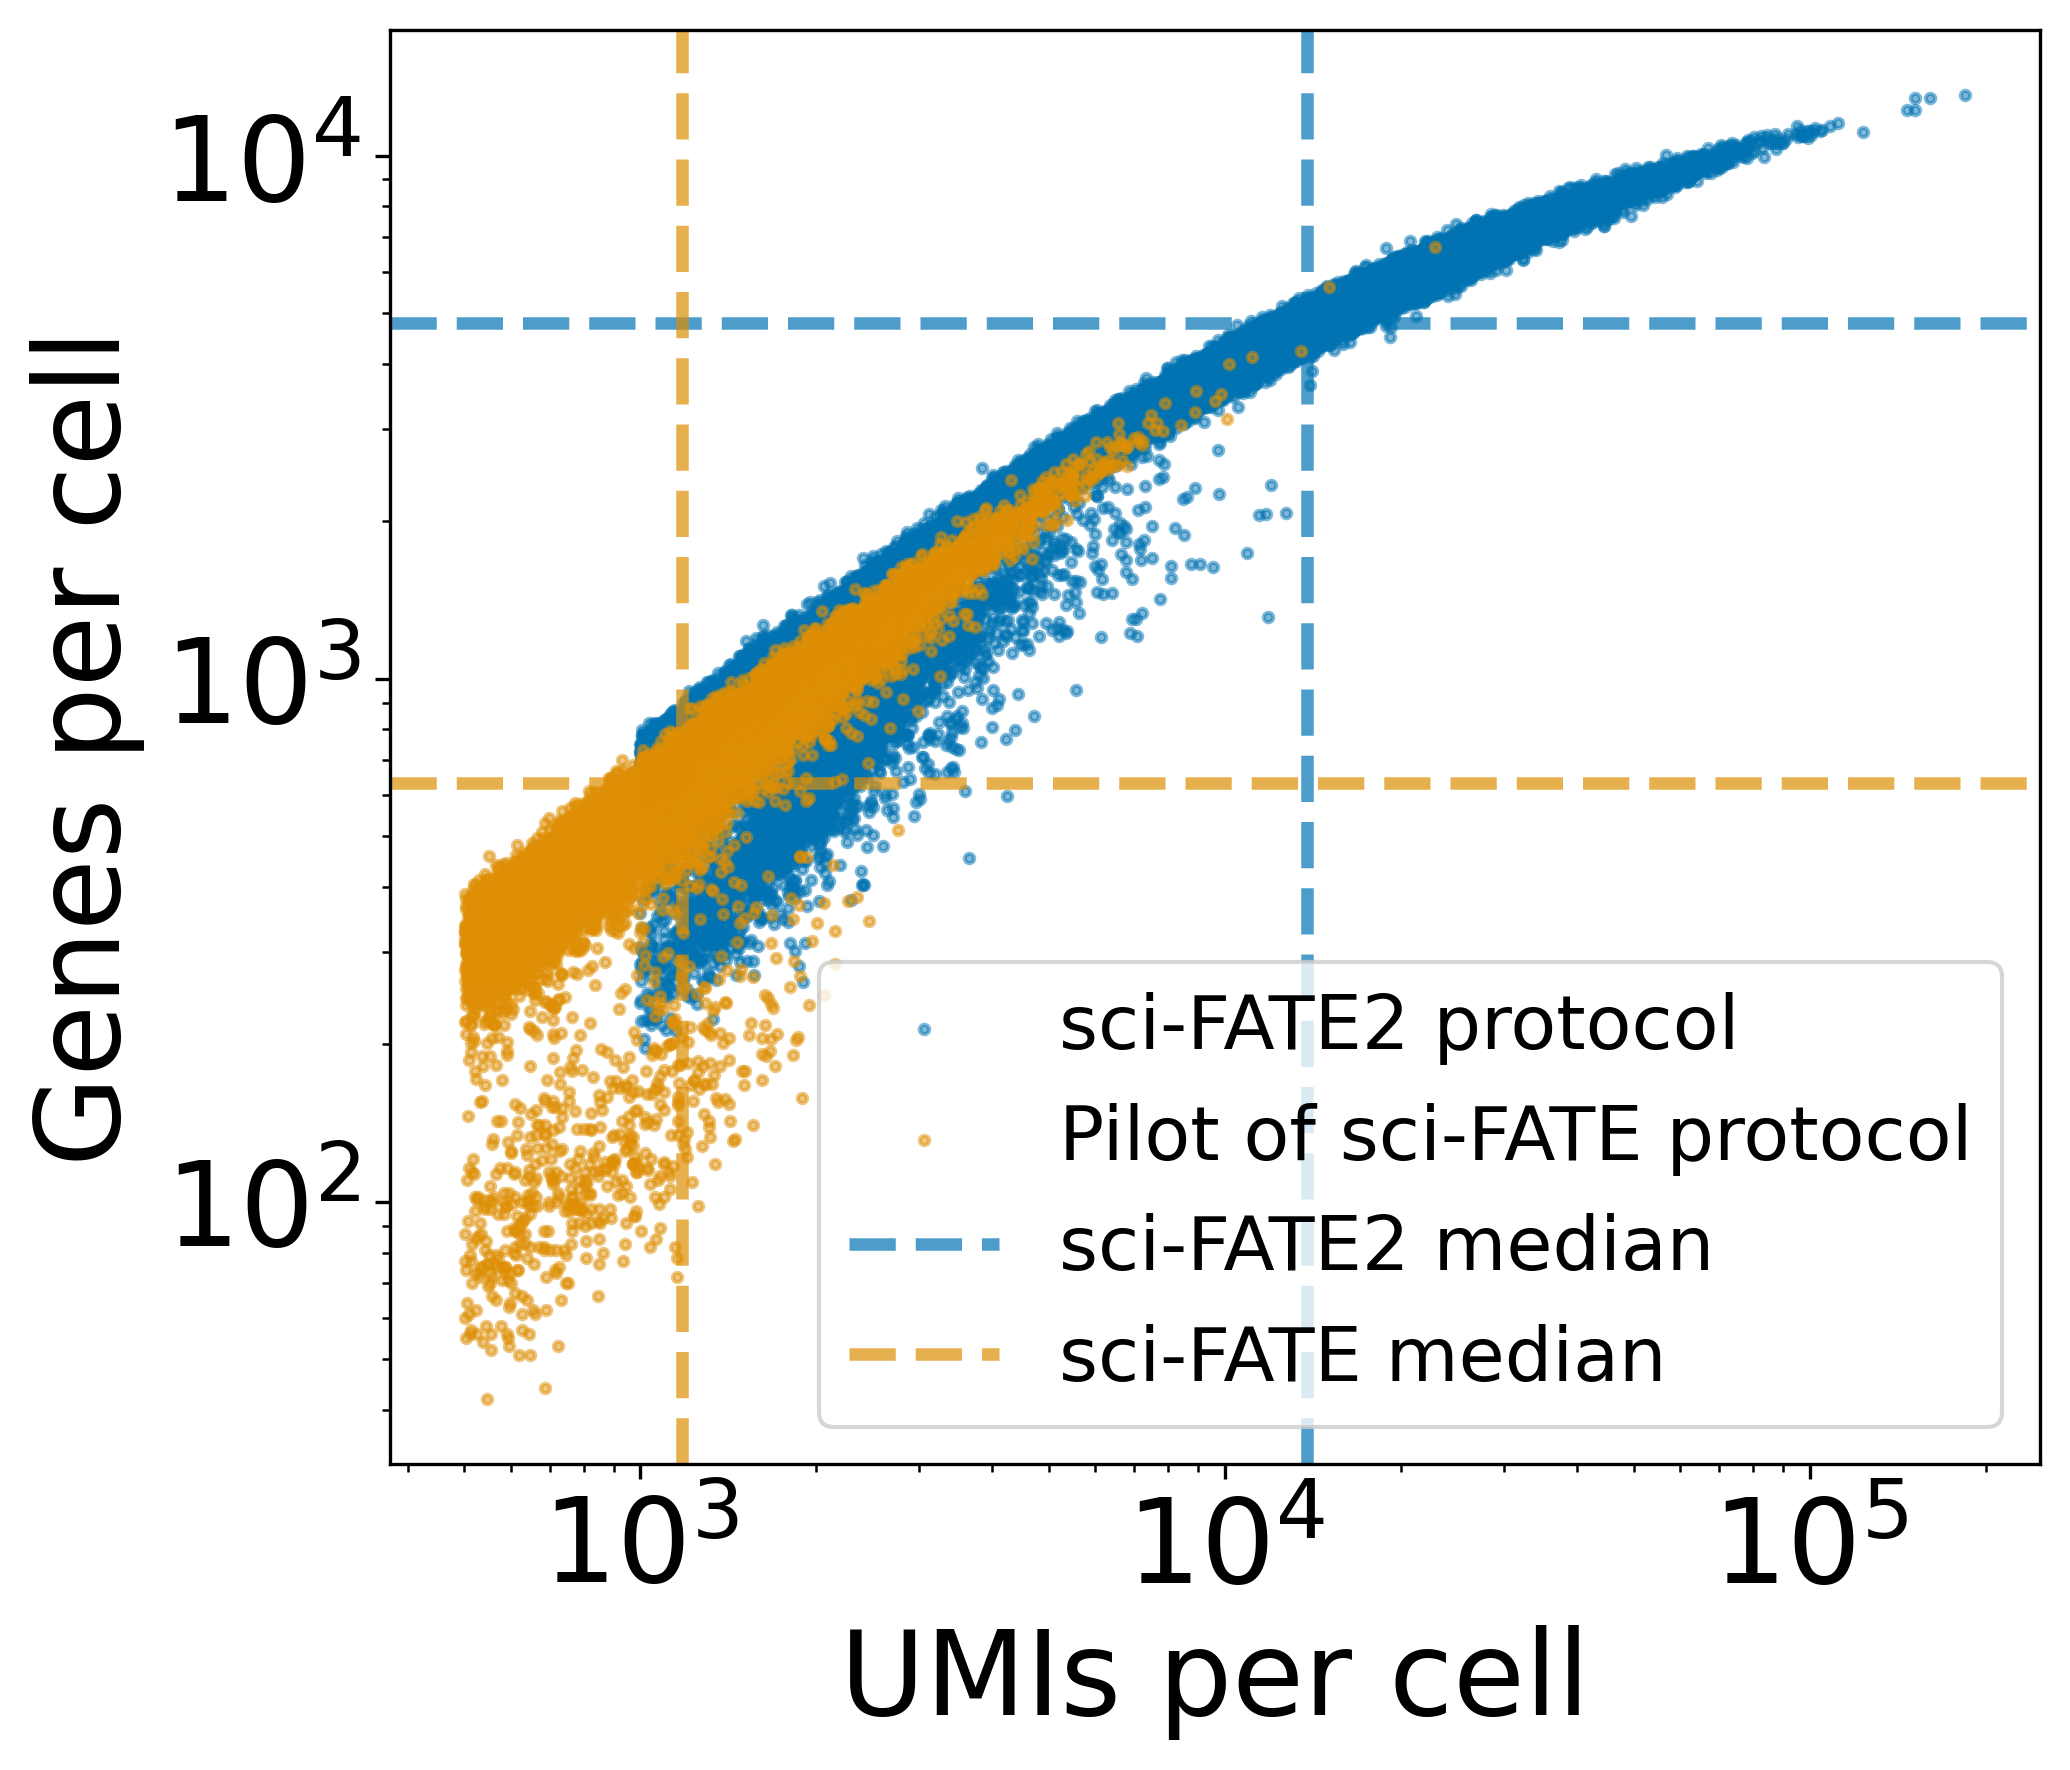

In [60]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.figure(figsize=(7,6), dpi=300)
plt.scatter(tumis,tgenes, s=5, alpha=0.5, label=f'sci-FATE2 protocol', color=colpal.cat1[0])
plt.scatter(pumis,pgenes, s=5, alpha=0.5, label=f'Pilot of sci-FATE protocol', color=colpal.cat1[1])
plt.xlabel("UMIs per cell", fontsize=28)
plt.ylabel("Genes per cell", fontsize=28)
plt.axhline(np.median(tgenes), linestyle='--', alpha=0.7, linewidth=3, label='sci-FATE2 median', color=colpal.cat1[0])
plt.axvline(np.median(tumis), linestyle='--', alpha=0.7, linewidth=3,  color=colpal.cat1[0])
plt.axhline(np.median(pgenes), linestyle='--', linewidth=3,  color=colpal.cat1[1], alpha=0.7, label='sci-FATE median')
plt.axvline(np.median(pumis), linestyle='--', linewidth=3,  alpha=0.7, color=colpal.cat1[1])
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=18) 

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('../figures/0.2.0_scifate_DQ_comparison.png', bbox_inches='tight')
plt.show()

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

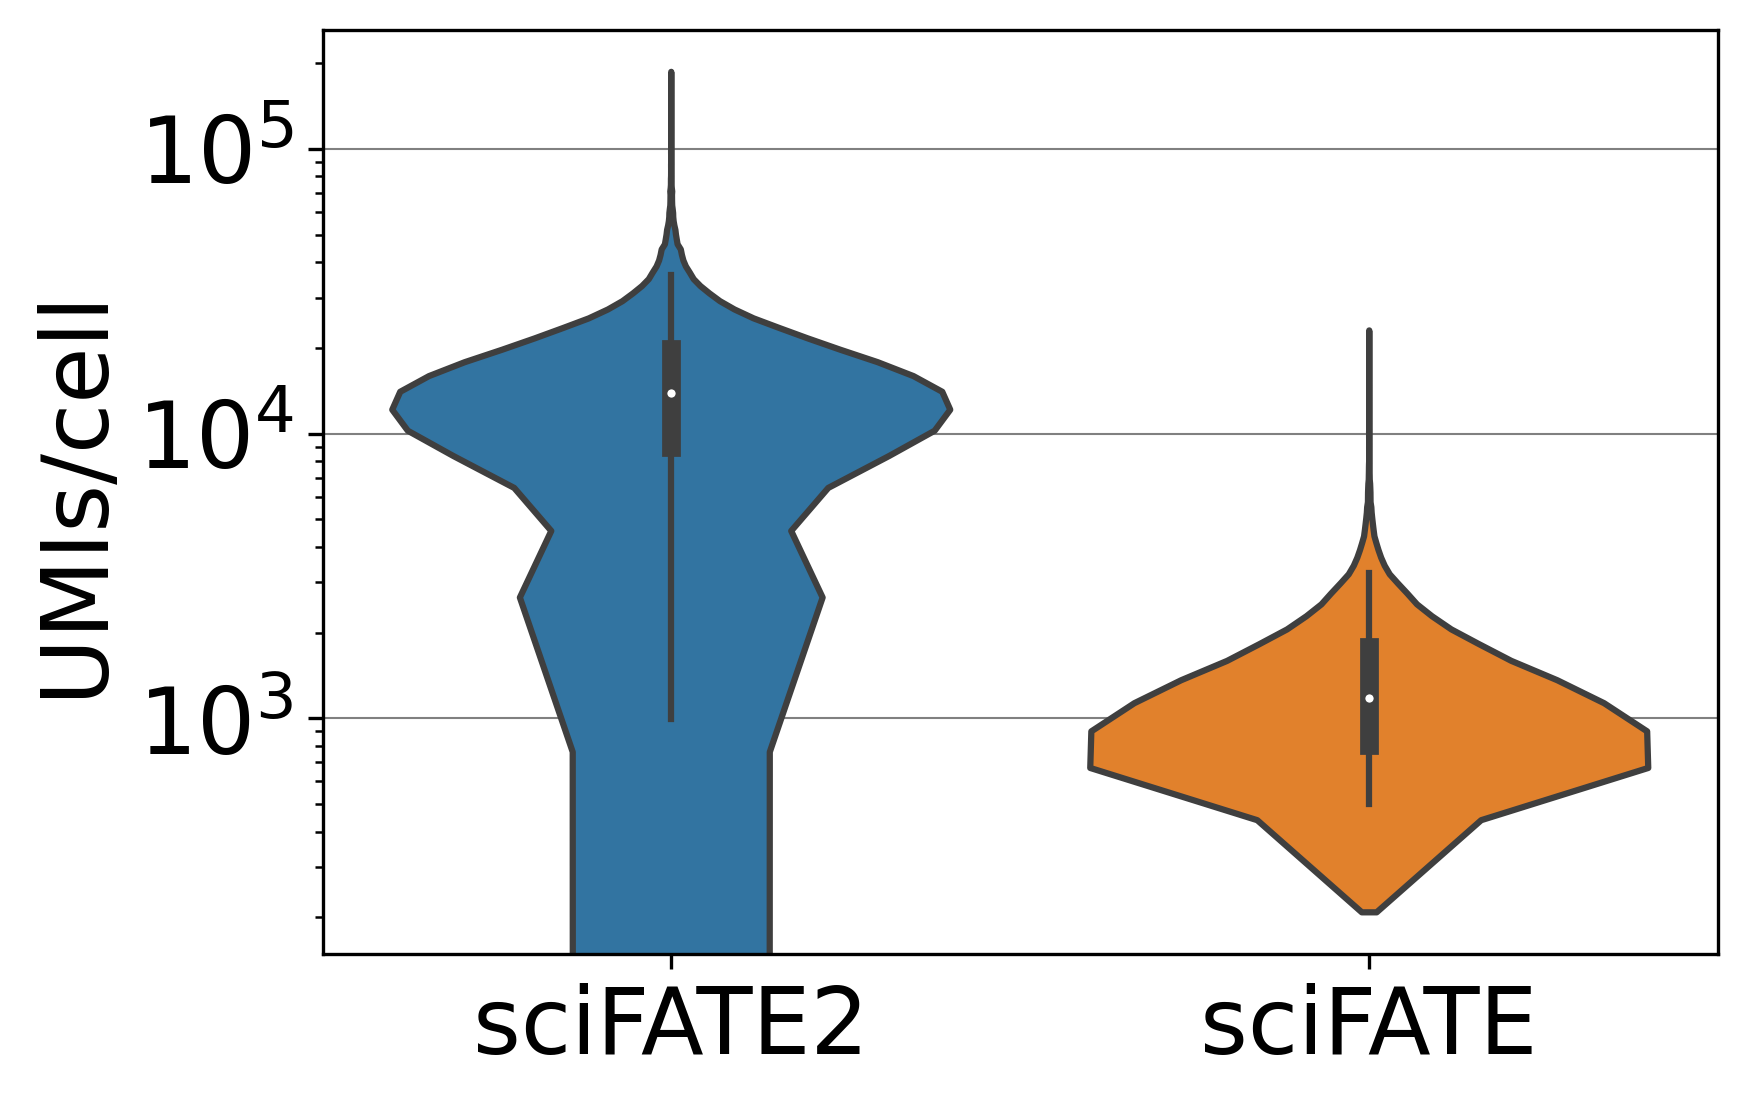

In [85]:
plt.figure(figsize=(6,4), dpi=300)
df = pd.DataFrame(
    {'UMIs':list(tumis)+list(pumis),
    'Method':['sciFATE2']*len(tumis)+['sciFATE']*len(pumis)}
)
sns.violinplot(data=df, x='Method', y='UMIs', scale='width')
plt.xlabel("")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel("UMIs/cell", fontsize=22)
plt.yscale("log")
plt.axhline(1000, zorder=-10, c='grey', linewidth=.5)
plt.axhline(10000, zorder=-10, c='grey', linewidth=.5)
plt.axhline(100000, zorder=-10, c='grey', linewidth=.5)
plt.savefig("../figures/0.2.9_UMIs_simple_plot.png")
plt.show()

# DQ2

In [86]:
adata = sc.read_h5ad('../data/pilot_protocol_comparison.h5ad')
adata.obs_names_make_unique()

umis = np.array(adata.X.sum(1)).flatten()
genes = np.array((adata.X>0).sum(1)).flatten()

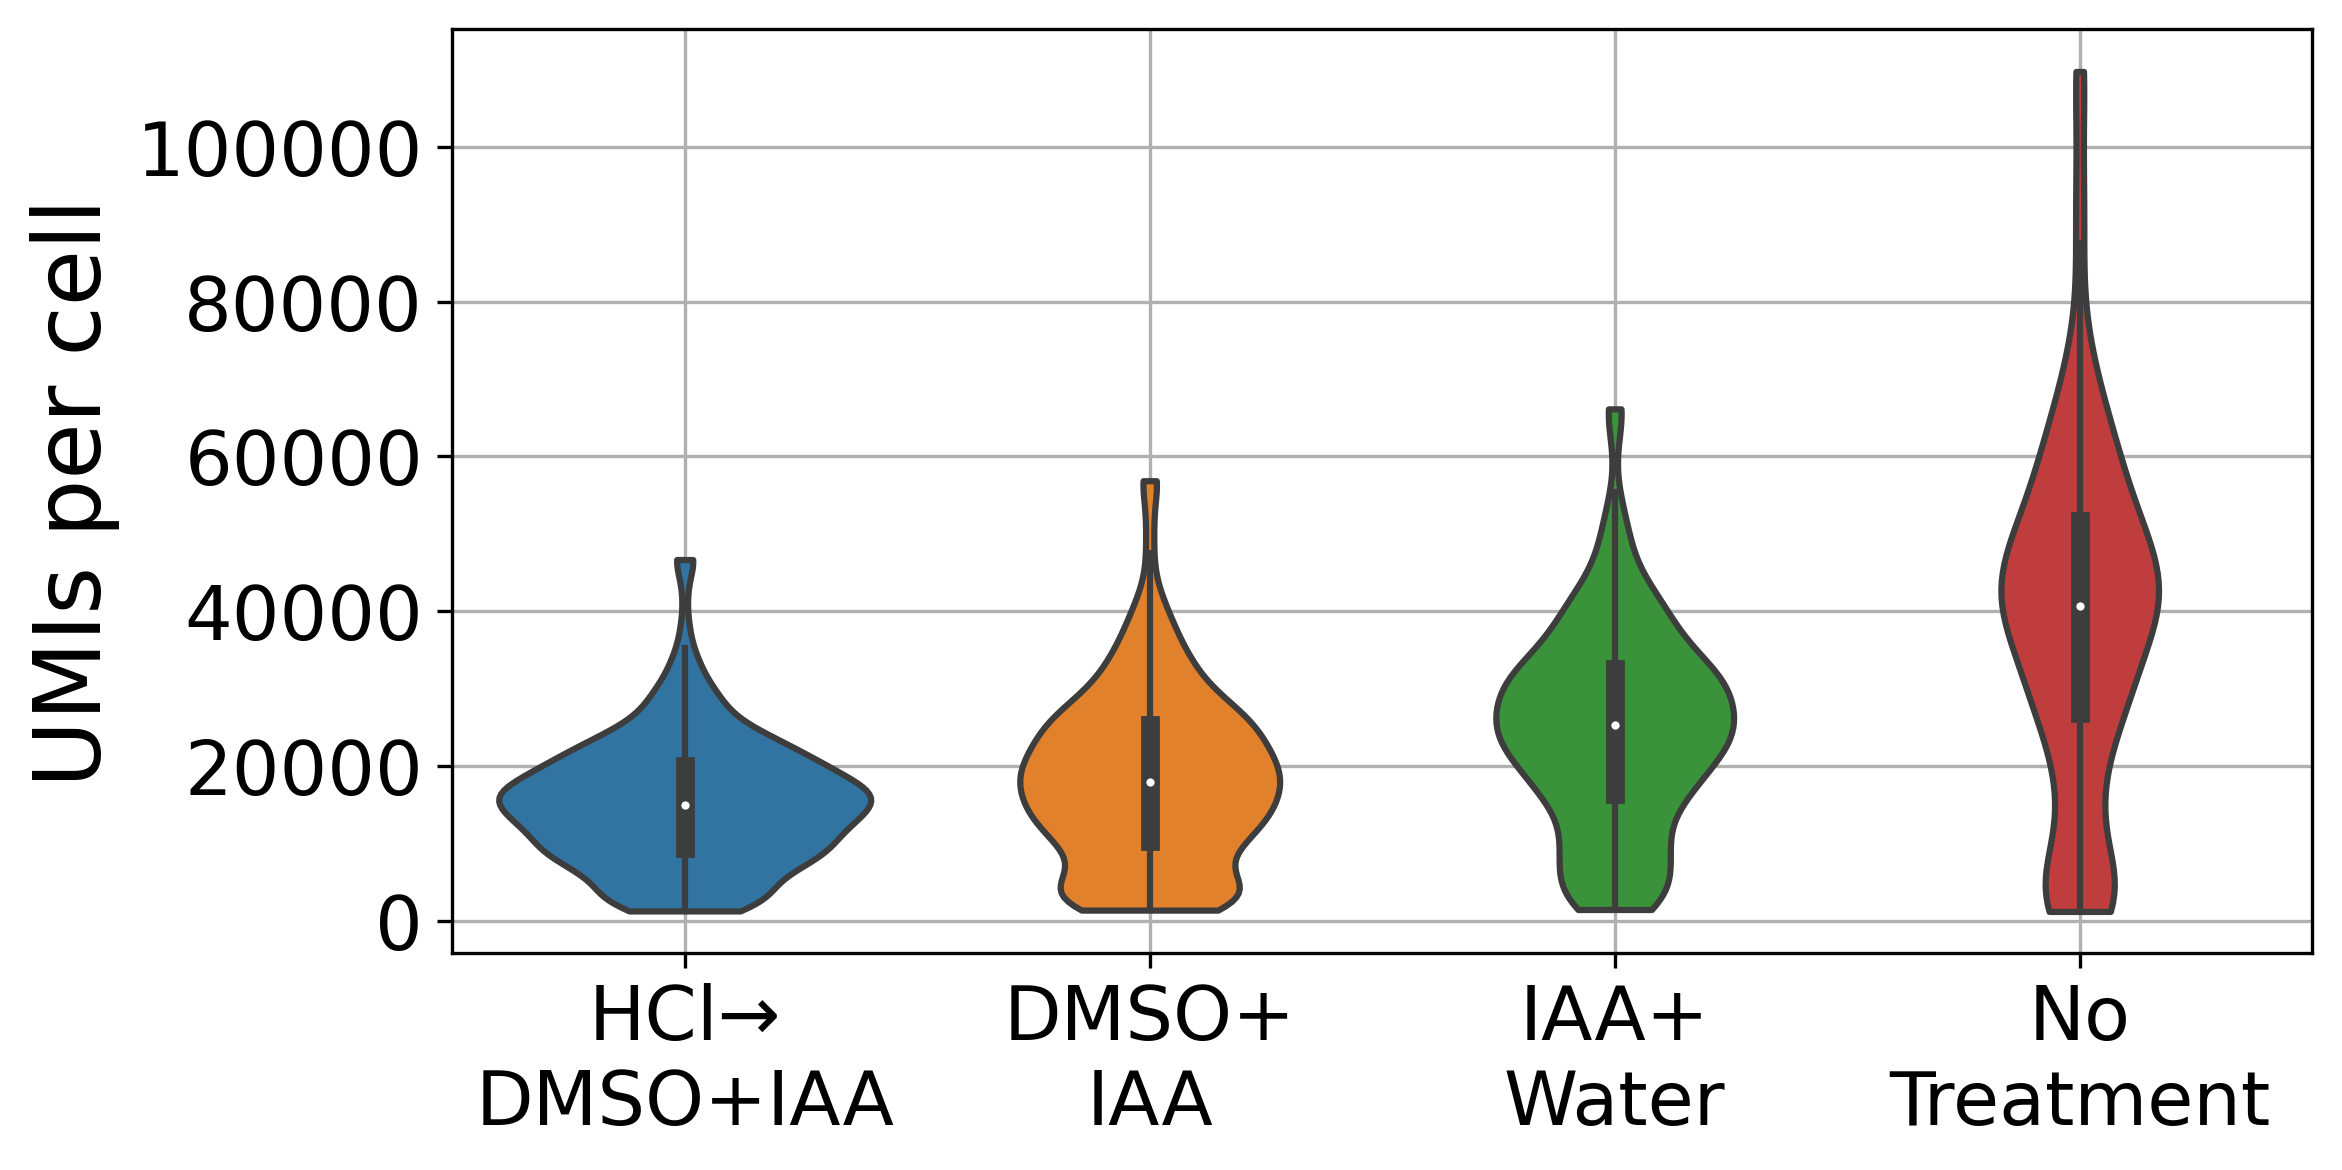

In [89]:
treat = adata[adata.obs.protocol=='old']
c_dict = {}
for cat in ['FT','DI', 'IO', 'NT']:
    sub = treat[treat.obs.treatment==cat]
    umi = np.array(sub.layers['total'].sum(1)).flatten()
    c_dict[cat] = umi
    
cond = []
umis = []
for key, val in c_dict.items():
    umi_clipped = np.clip(val, np.percentile(val, 1), np.percentile(val, 99))
    cond.extend([key]*len(umi_clipped))
    umis.extend(umi_clipped)
df = pd.DataFrame({"Condition":cond,"UMIs":umis})

plt.figure(figsize=(8,4), dpi=300)

# Capture the axes object returned by sns.violinplot
ax = sns.violinplot(y="UMIs", x="Condition", data=df, cut=0, cmap=colpal.cmap_cat1)

# Adjust axes and labels
plt.xticks([0,1,2,3], labels=["HCl→\nDMSO+IAA",'DMSO+\nIAA','IAA+\nWater','No\nTreatment'], rotation=0, fontsize=18)
plt.xlabel("")
plt.yticks(fontsize=18)
plt.ylabel("UMIs per cell", fontsize=22)

# Make grid visible and set behind other elements
ax.grid(True)
ax.set_axisbelow(True)

# Set the plot scales and other properties
# plt.yscale('log')
ax.set_facecolor('white')
plt.savefig('../figures/0.2.1_HCL_DMSO_UMIs.png', bbox_inches='tight')
plt.show()

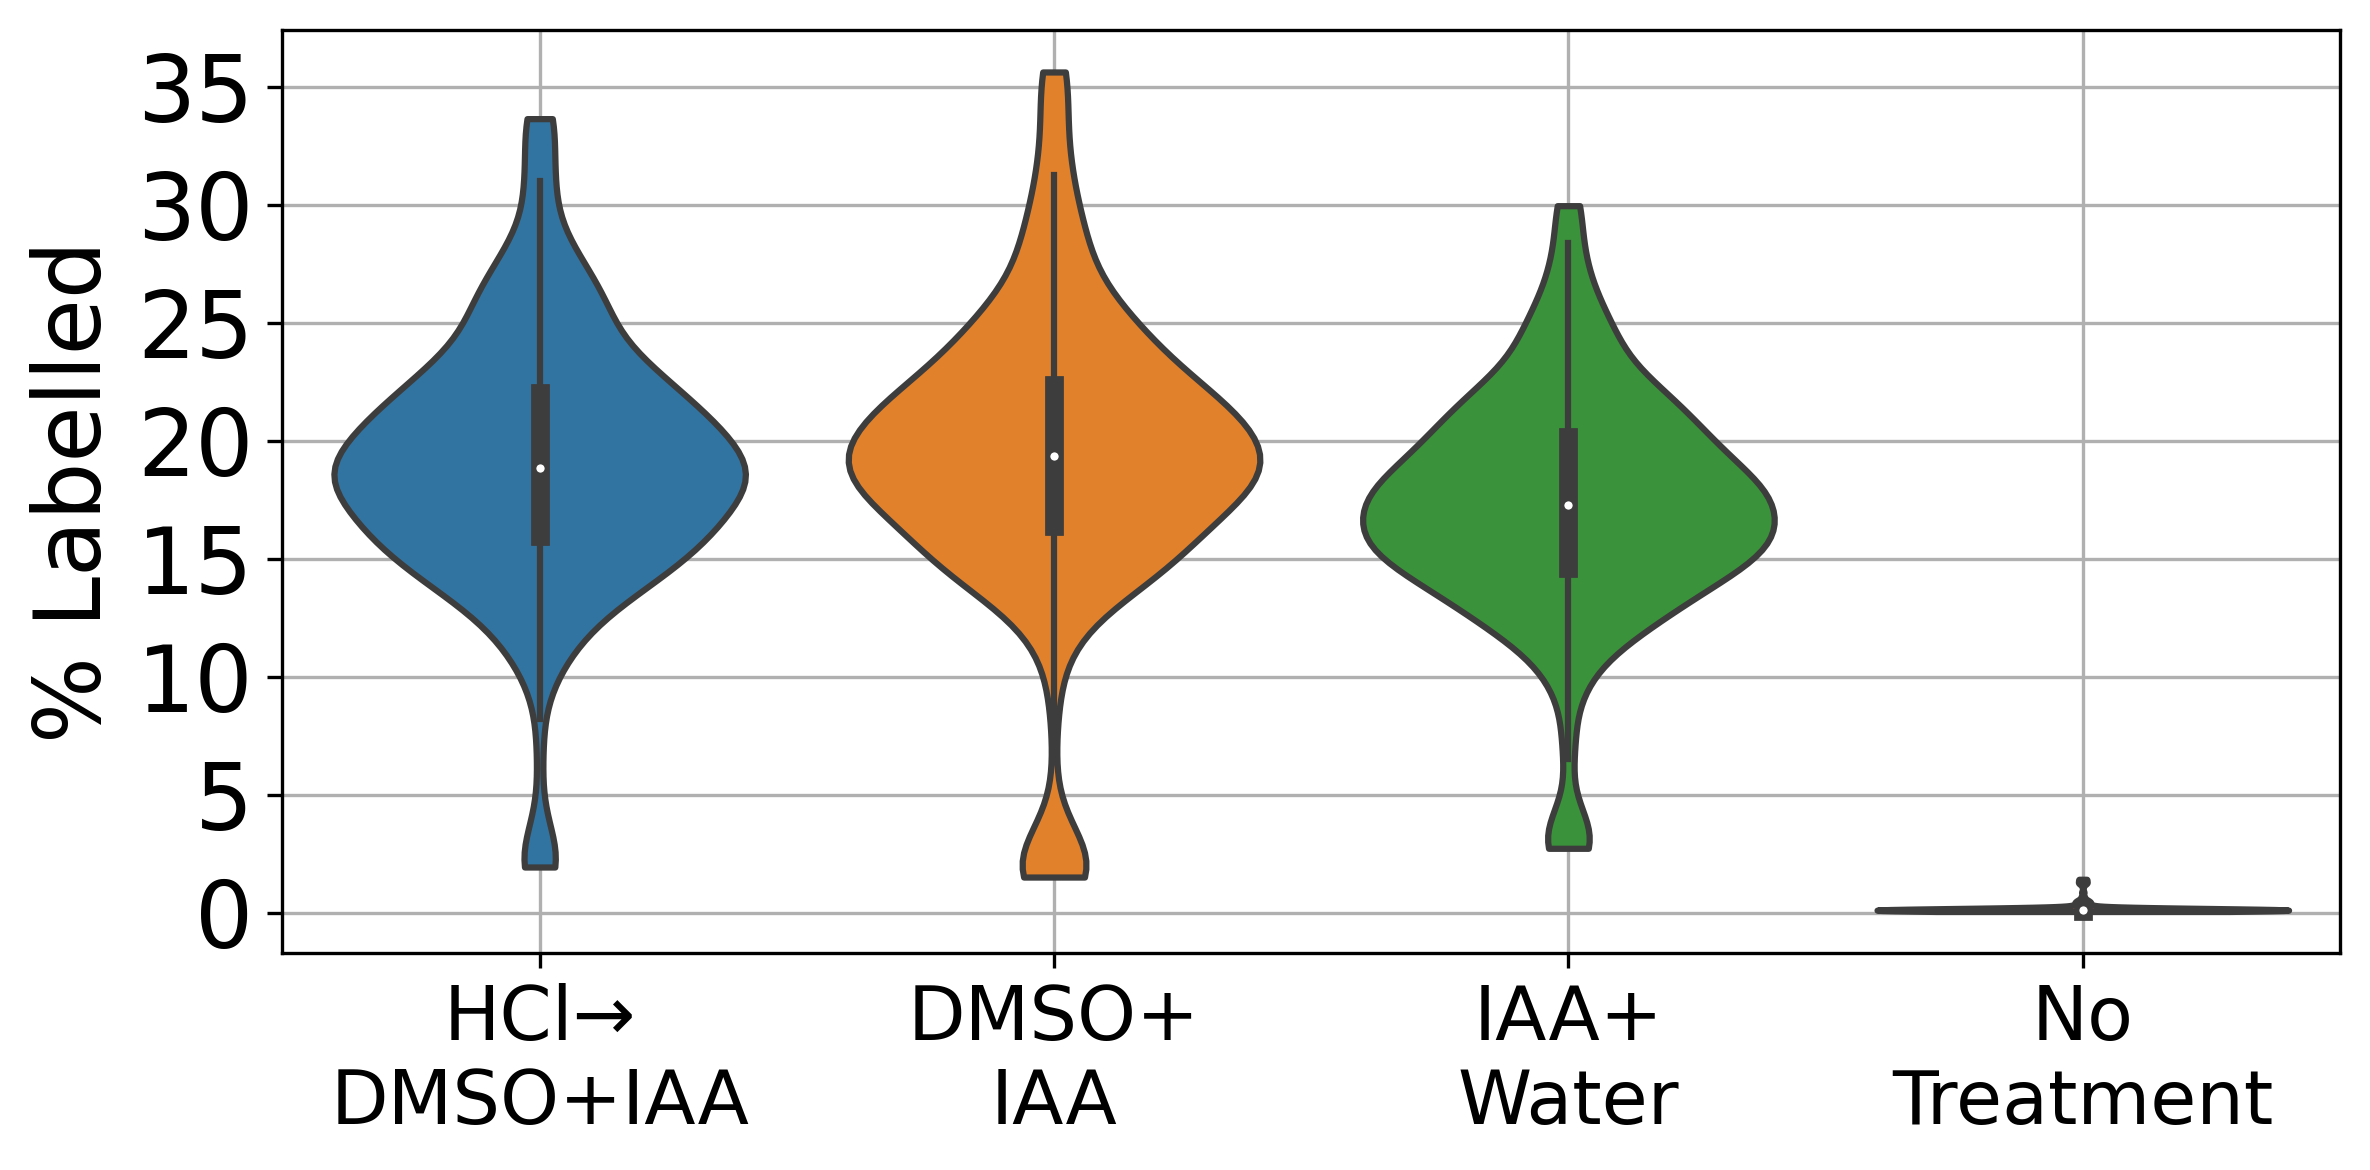

In [90]:
l_dict = {}
for cat in ['FT','DI', 'IO', 'NT']:
    sub = treat[treat.obs.treatment==cat]
    lab = np.array(sub.layers['labeled_TC'].sum(1)).flatten() / np.array(sub.layers['total'].sum(1)).flatten() 
    l_dict[cat] = lab
    
cond = []
labs = []
for key, val in l_dict.items():
    lab_clipped = np.clip(val, np.percentile(val, 1), np.percentile(val, 99))
    cond.extend([key]*len(lab_clipped))
    labs.extend(100*lab_clipped)
df = pd.DataFrame({"Condition":cond,"% Labelled":labs})

plt.figure(figsize=(8,4), dpi=300)
ax = sns.violinplot(y="% Labelled", x="Condition", data=df, cut=0, scale='width', cmap=colpal.cmap_cat1, zorder=-1)
plt.xticks([0,1,2,3], labels=["HCl→\nDMSO+IAA",'DMSO+\nIAA','IAA+\nWater','No\nTreatment'], rotation=0, fontsize=18)
plt.xlabel("")
plt.yticks(fontsize=22)
plt.ylabel("% Labelled", fontsize=22)
ax.set_facecolor('white')
ax.grid(True)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig("../figures/0.2.2_HCL_DMSO_labelling.png", bbox_inches='tight')
plt.show()




# DQ3

In [91]:
p_dict = {}

  
prot = adata[adata.obs.treatment=='IO']
sub = prot[prot.obs.protocol=='old']
umi = np.array(sub.layers['total'].sum(1)).flatten()
gen = np.array((sub.layers['total']>0).sum(1)).flatten()
p_dict['scifate'] = (umi,gen)

prot = adata[adata.obs.treatment=='NT']
for p in ['old', 'pub']:
    sub = prot[prot.obs.protocol==p]
    umi = np.array(sub.layers['total'].sum(1)).flatten()
    gen = np.array((sub.layers['total']>0).sum(1)).flatten()
    p_dict[p] = (umi,gen)

cond = []
umis = []
gens = []
for key, val in p_dict.items():
    umi, gen = val
    cond.extend([key]*len(umi))
    umis.extend(umi)
    gens.extend(gen)
df = pd.DataFrame({"Condition":cond,"UMIs":umis,"Genes":gens})



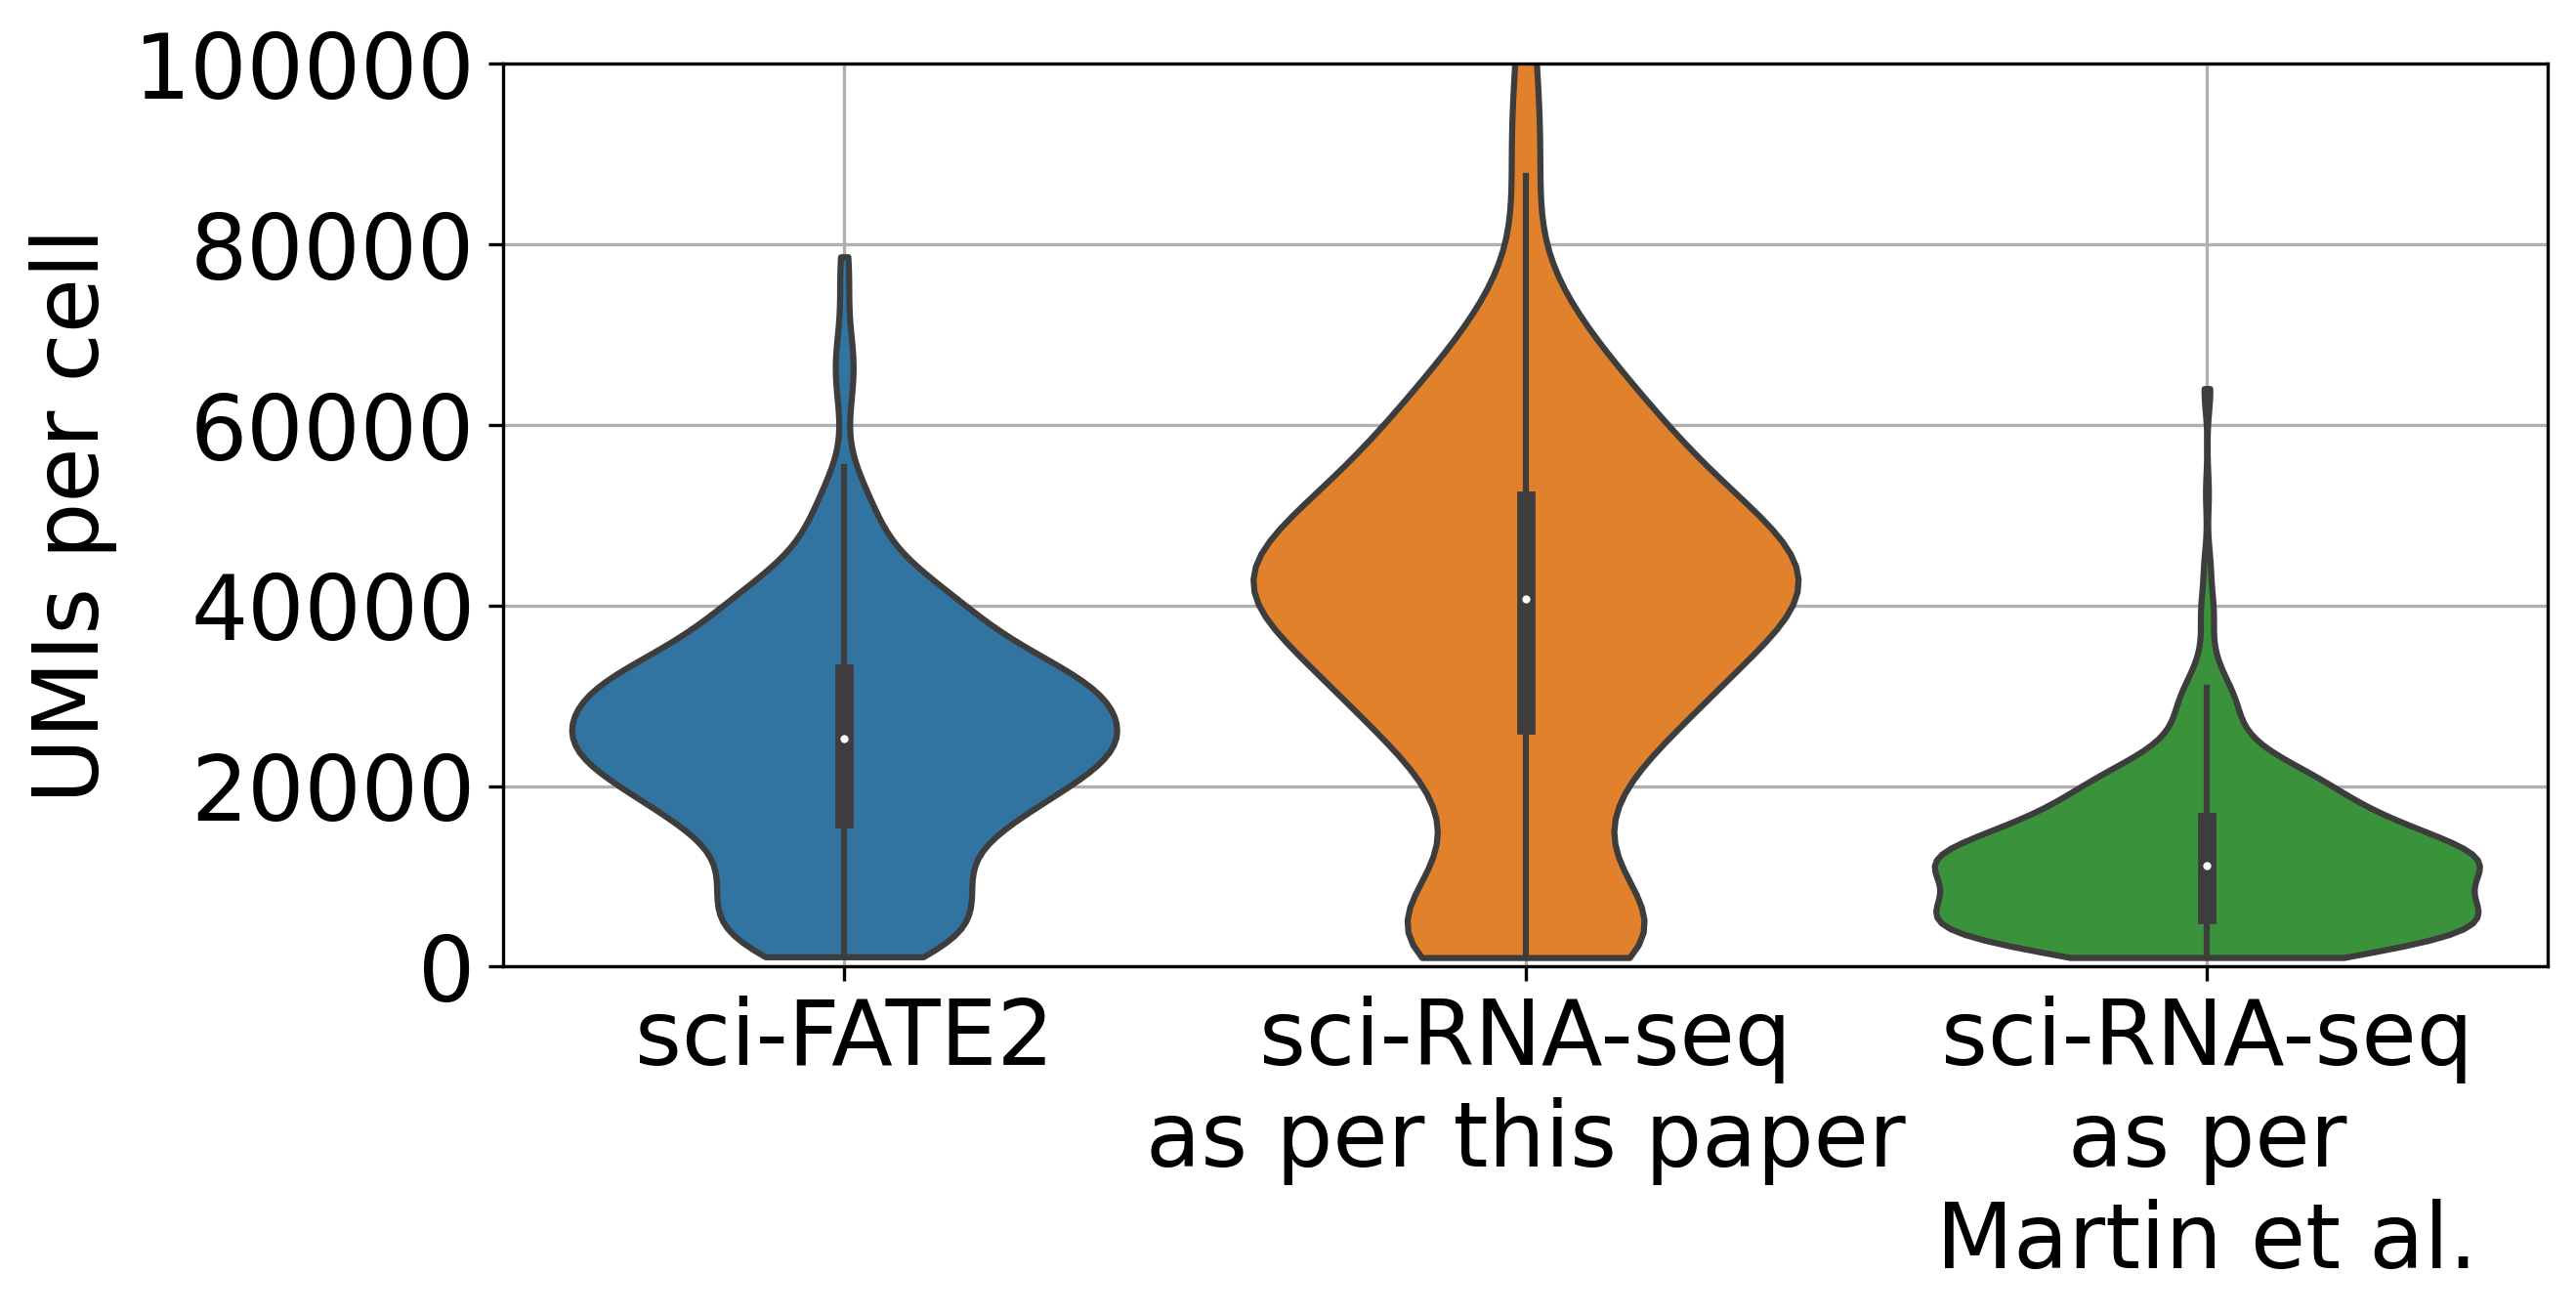

In [95]:
plt.figure(figsize=(9,4), dpi=300)
ax = sns.violinplot(data=df, x='Condition',y='UMIs', scale='width', cut=0, cmap=colpal.cmap_cat1)
plt.xticks([0,1,2], labels=['sci-FATE2','sci-RNA-seq\nas per this paper','sci-RNA-seq\nas per\nMartin et al.'], 
           rotation=0, fontsize=22)
plt.xlabel("")
plt.yticks(fontsize=22)
plt.ylabel("UMIs per cell", fontsize=22)
plt.ylim((0,100000))

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
ax.grid(True)
ax.set_axisbelow(True)

plt.savefig('../figures/0.2.3_Martinetal_comparison_UMIs.png', bbox_inches='tight')
plt.show()

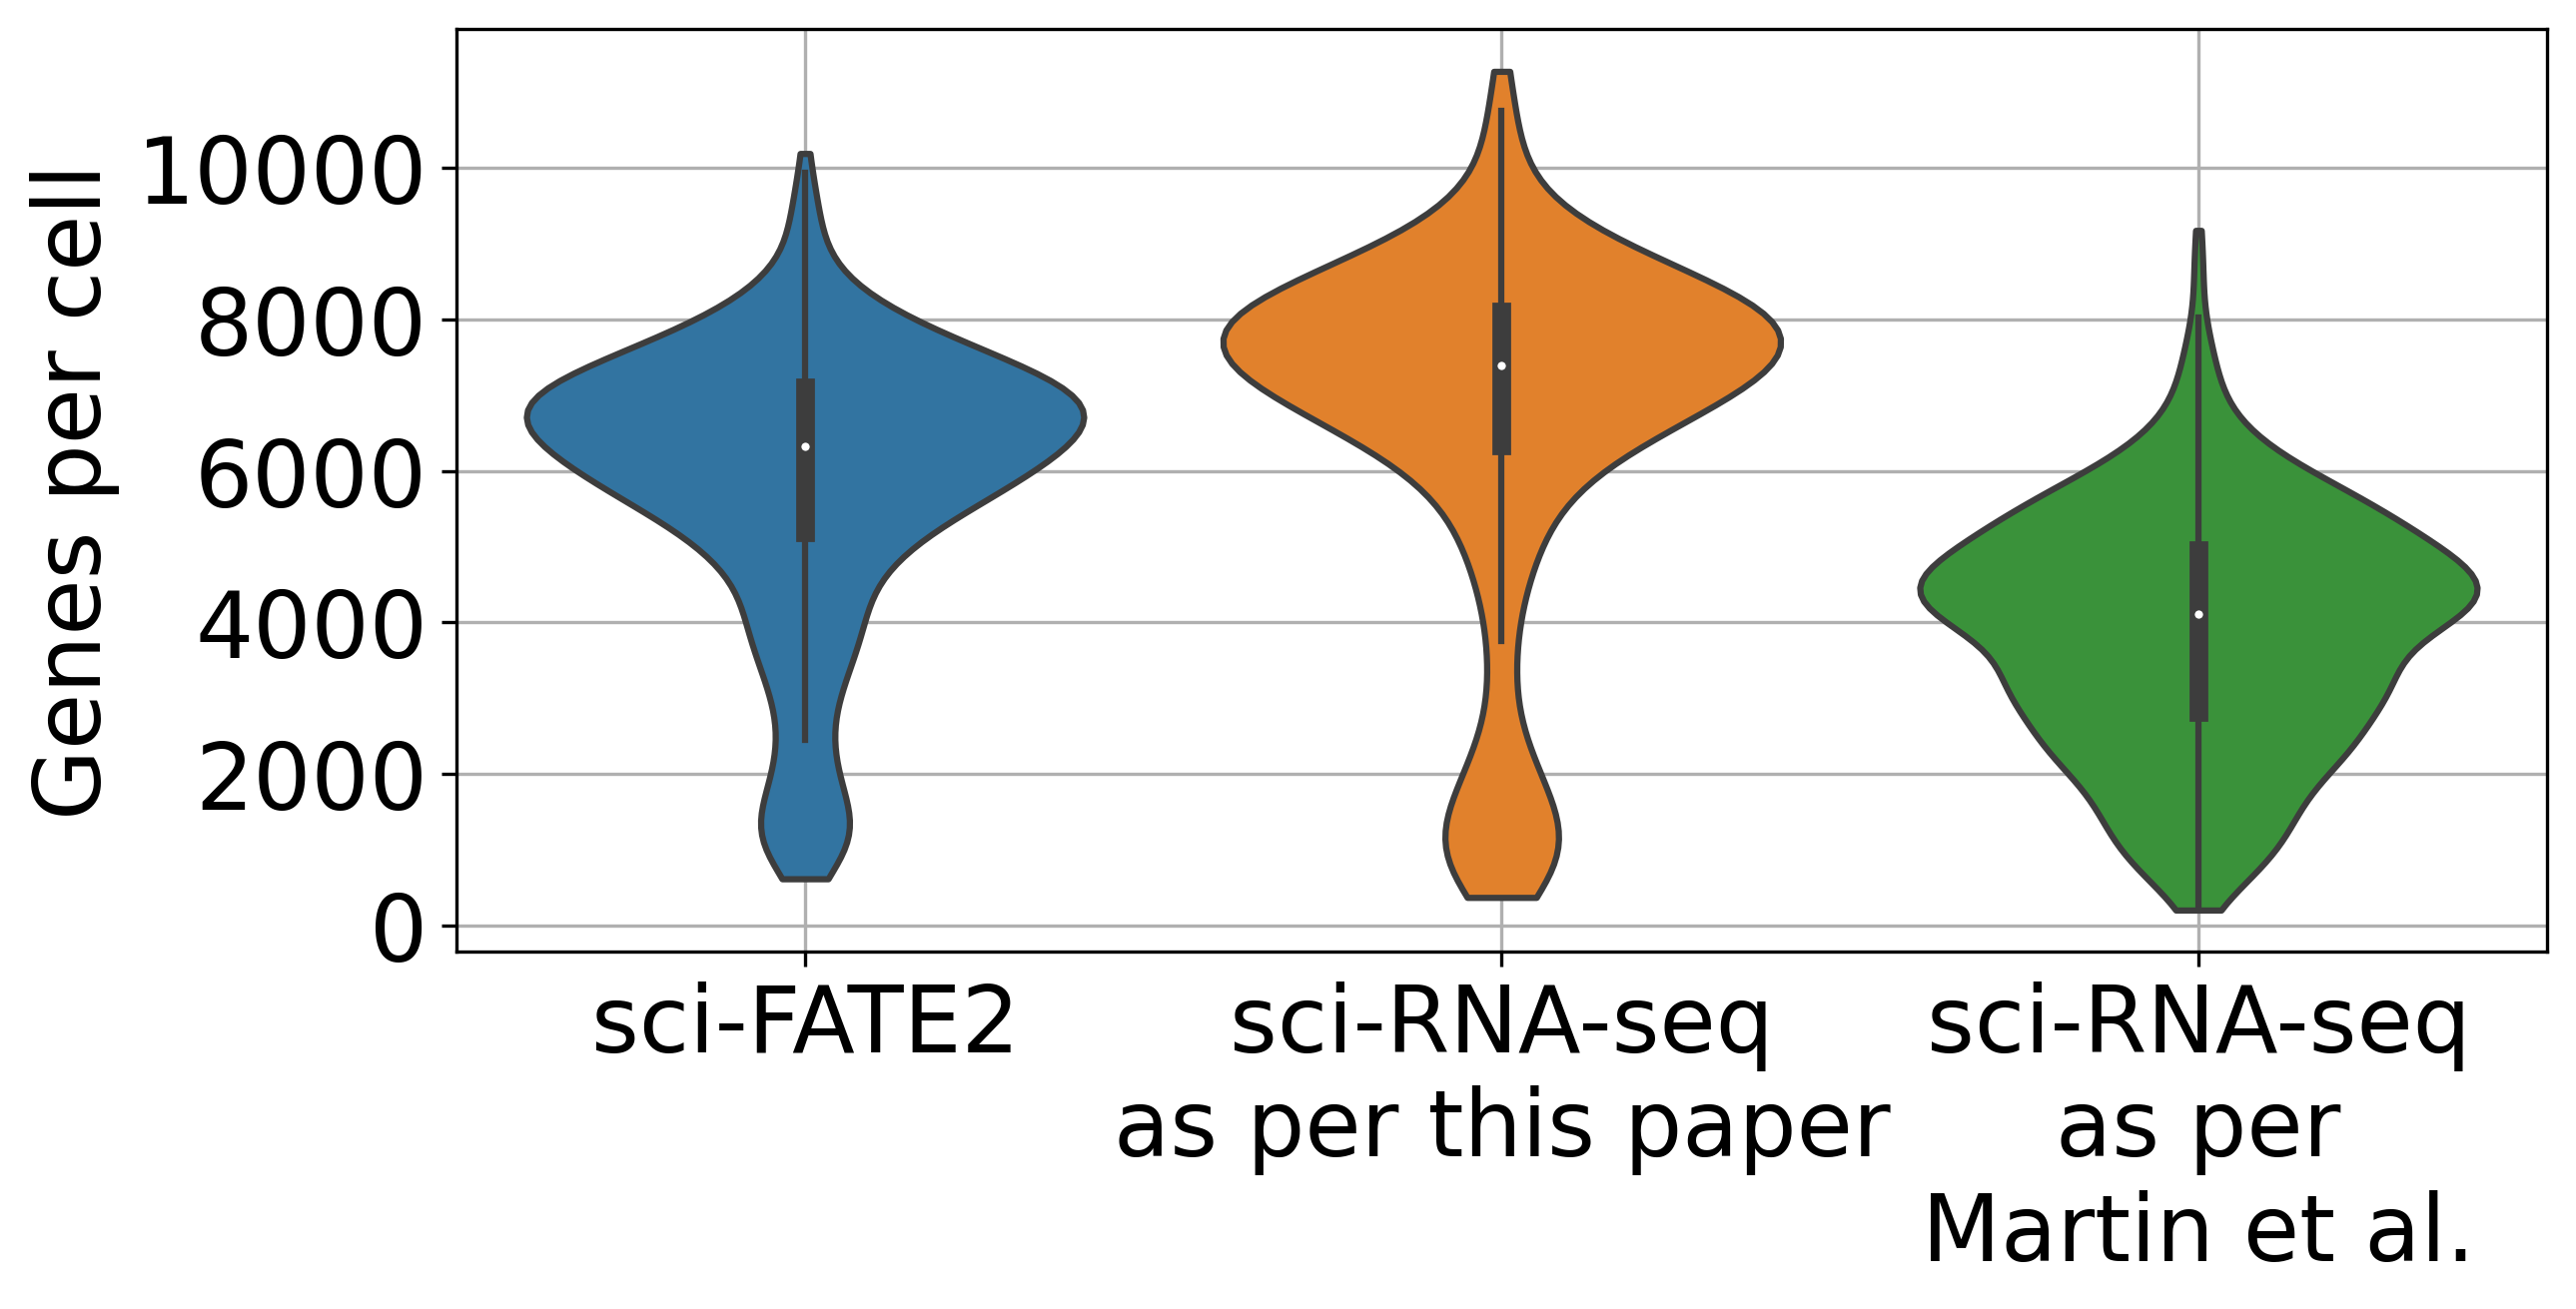

In [97]:
plt.figure(figsize=(9,4), dpi=300)
ax = sns.violinplot(data=df, x='Condition',y='Genes', scale='width', cut=0, cmap=colpal.cmap_cat1)
plt.xticks([0,1,2], labels=['sci-FATE2','sci-RNA-seq\nas per this paper','sci-RNA-seq\nas per\nMartin et al.'], 
           rotation=0, fontsize=22)
plt.xlabel("")
plt.yticks(fontsize=22)
plt.ylabel("Genes per cell", fontsize=22)
# plt.ylim((0,100000))

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

ax.grid(True)
ax.set_axisbelow(True)
        
plt.savefig('../figures/0.2.4_Martinetal_comparison_genes.png', bbox_inches='tight')
plt.show()

# L1

In [98]:
sub = adata[adata.obs.protocol=='old']
nt = sub[sub.obs.treatment=='NT']
io = sub[sub.obs.treatment=='IO']

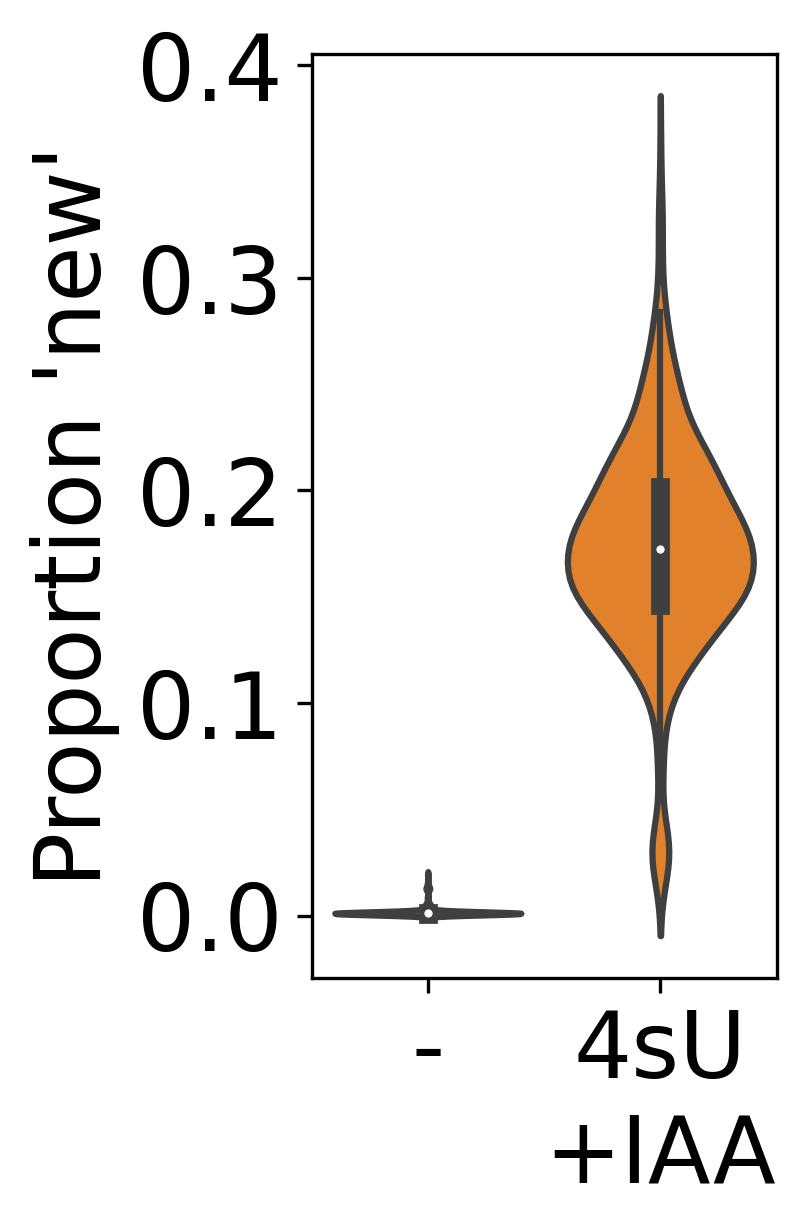

In [113]:
nt_pct = np.array(nt.layers['labeled_TC'].sum(1)/nt.layers['total'].sum(1)).flatten()
io_pct = np.array(io.layers['labeled_TC'].sum(1)/io.layers['total'].sum(1)).flatten()

df = pd.DataFrame(
    {'Condition':['-']*len(nt_pct) + ['4sU\n+IAA']*len(io_pct),
     'Labelled %': list(nt_pct) + list(io_pct)})

plt.figure(figsize=(2,4), dpi=300)
sns.violinplot(data=df, x='Condition', y='Labelled %', size=3, scale='width', cmap=colpal.cmap_cat1)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=22)
plt.ylabel("Proportion 'new'", fontsize=22)
plt.yticks([0,0.1,0.2,0.3,0.4],fontsize=22)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.2.5_specific_labelling.png', bbox_inches='tight')
plt.show()

# L2

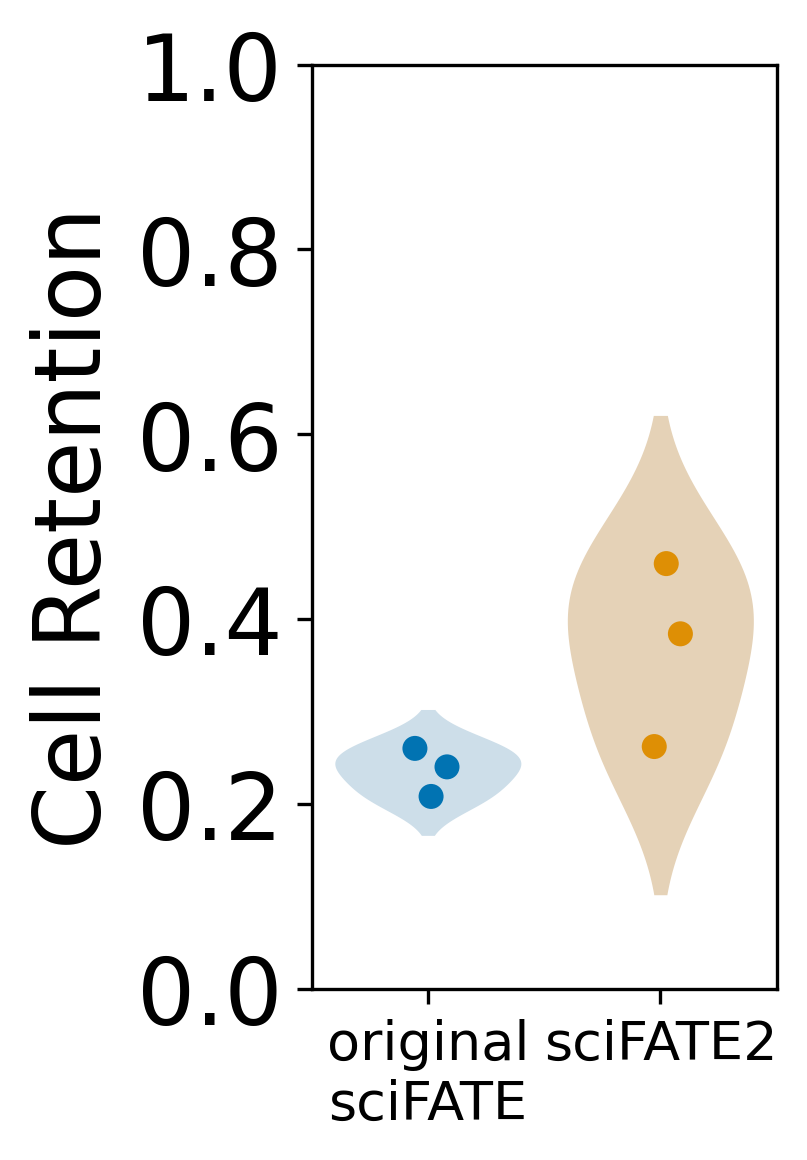

In [104]:
# experimental data:
new = np.array([2.3, 1.92, 1.31])
old = np.array([1.3,1.04,1.2]) 

# per starting point
old_loss = old / 5
new_loss = new / 5

df = {'loss': list(old_loss) + list(new_loss),
 'method':['old']*3 + ['new']*3}

plt.figure(figsize=(2,4), dpi=300)
mypal={'old':'#bfe1f7','new':'#fcd6a0'} # enforcing an alpha-like effect
sns.stripplot(data=df, x='method', y='loss', size=6, palette='colorblind')
sns.violinplot(data=df, x='method', y='loss', size=10, scale='width', alpha=1, 
               palette=mypal, saturation=0.5, inner=None, linewidth=0, )
plt.ylim((0,1))
plt.ylabel("Cell Retention", fontsize=22)
plt.xlabel("")
plt.xticks([0,1], labels=['original\nsciFATE','sciFATE2'], rotation=0, fontsize=13)
plt.yticks(fontsize=22)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.2.6_cell_retention.png', bbox_inches='tight')
plt.show()

# L3

In [105]:
cnt = sc.read_h5ad('../data/adata_unprocessed.h5ad')
est = sc.read_h5ad('../data/adata_unprocessed_estimate.h5ad')

In [106]:
df = pd.DataFrame(
    {'data':list((np.array(cnt.layers['new'].sum(1)).flatten() / np.array(cnt.layers['total'].sum(1)).flatten()))+
    list((np.array(est.layers['new_estimated'].sum(1)).flatten() / np.array(cnt.layers['total'].sum(1)).flatten())),
    'method':['Counting']*cnt.shape[0]+['Estimating']*est.shape[0]
    }
)

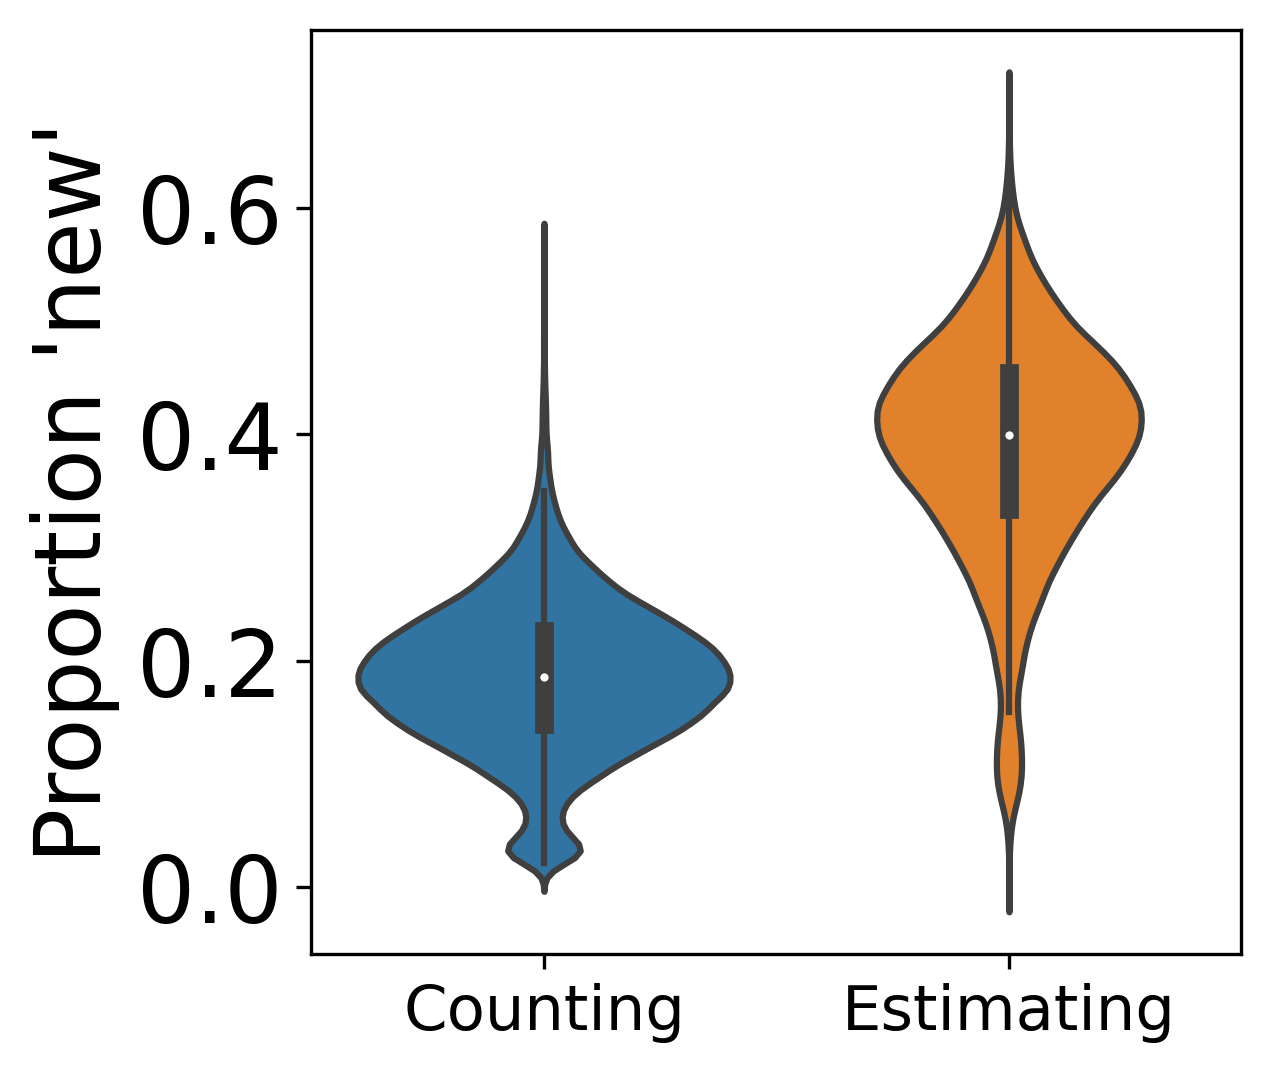

In [112]:
plt.figure(figsize=(4,4), dpi=300)
sns.violinplot(data=df, x='method', y='data')
plt.xlabel("")
plt.yticks([0,0.2,0.4,0.6], fontsize=22)
plt.xticks(fontsize=15)
plt.ylabel("Proportion 'new'", fontsize=22)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.2.7_est_cnt_proportions.png', bbox_inches='tight')
plt.show()

In [114]:
xest = np.asarray(est.layers['old_estimated'].A)
yest = np.asarray(est.layers['new_estimated'].A)
xcnt = np.asarray(cnt.layers['old'].A)
ycnt = np.asarray(cnt.layers['new'].A)

est_score = np.zeros(len(est.var_names))
cnt_score = np.zeros(len(cnt.var_names))

for i in trange(len(est.var_names)):
    xe = xest[:,i]
    ye = yest[:,i]
    est_score[i] = np.mean((xe!=0)&(ye!=0))
    xc = xcnt[:,i]
    yc = ycnt[:,i]
    cnt_score[i] = np.mean((xc!=0)&(yc!=0))
    

100%|██████████| 24967/24967 [00:45<00:00, 553.81it/s]


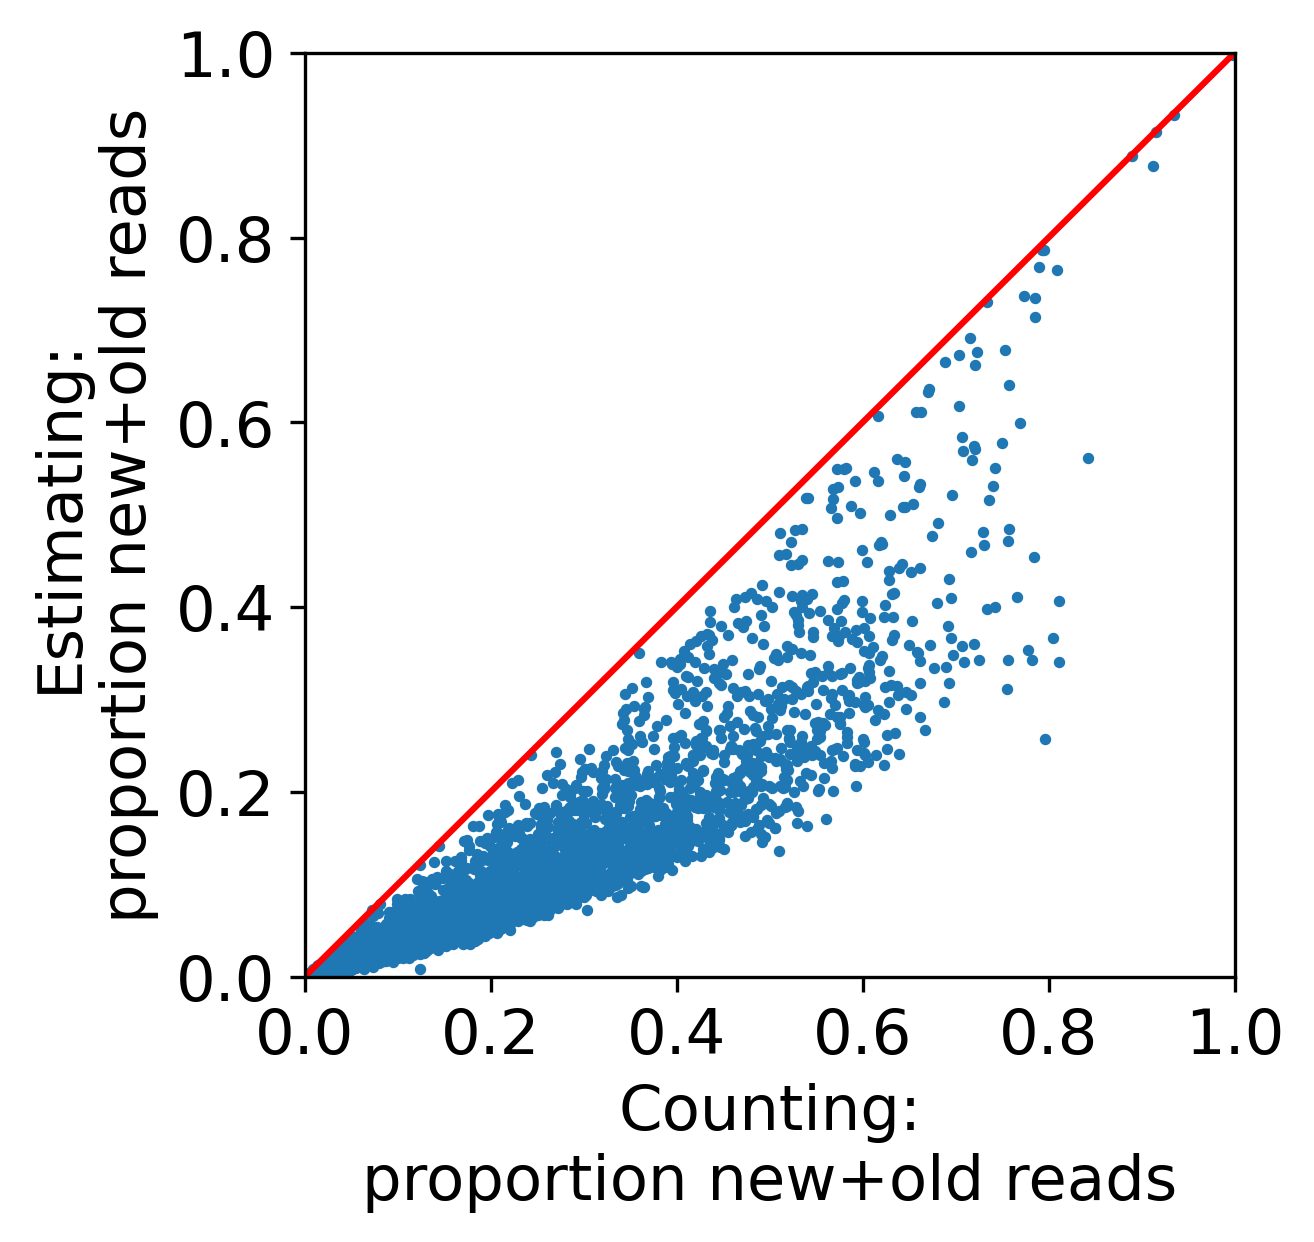

In [119]:
plt.figure(figsize=(4,4), dpi=300)
plt.scatter(cnt_score,est_score, s=3)
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10), color='r')
plt.xlabel("Counting:\nproportion new+old reads", fontsize=15)
plt.ylabel("Estimating:\nproportion new+old reads", fontsize=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig("../figures/0.2.8_est_cnt_balance_means.png", bbox_inches='tight')
plt.show()

In [120]:
xeg1 = np.asarray(est[:,'Olig2'].layers['old_estimated'].A)
yeg1 = np.asarray(est[:,'Olig2'].layers['new_estimated'].A)
xeg2 = np.asarray(cnt[:,'Olig2'].layers['old'].A)
yeg2 = np.asarray(cnt[:,'Olig2'].layers['new'].A)

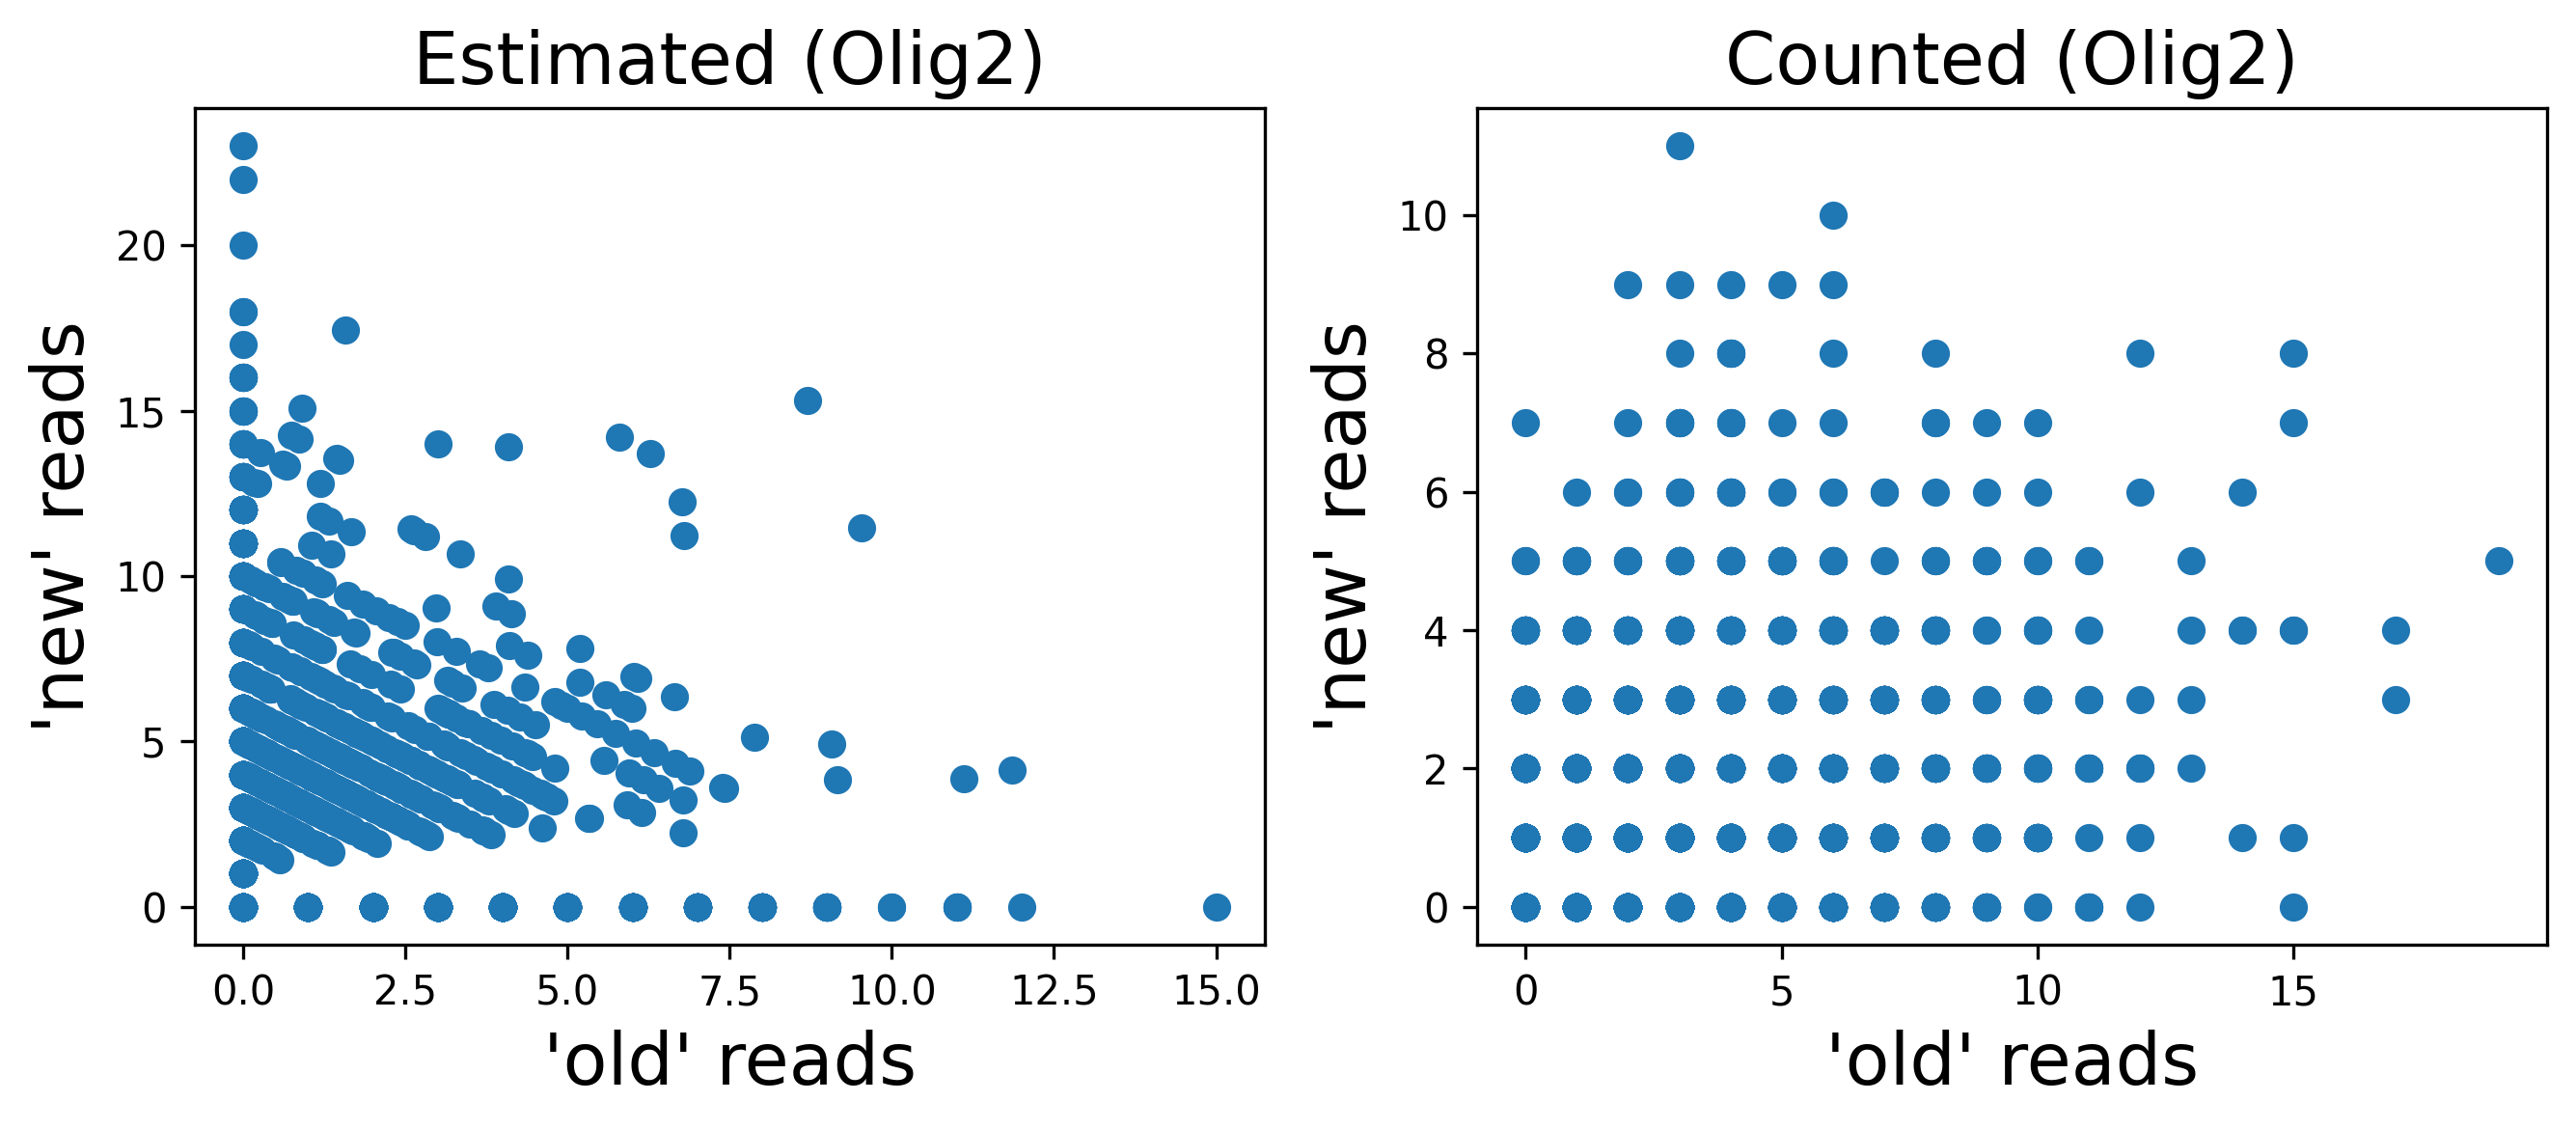

In [121]:
fig = plt.figure(figsize=(9,4), dpi=300)
ax1, ax2 = fig.subplots(1,2)
ax1.scatter(xeg1,yeg1)
ax1.set_xlabel("'old' reads", fontsize=18)
ax1.set_ylabel("'new' reads", fontsize=18)
ax2.scatter(xeg2,yeg2)
ax2.set_xlabel("'old' reads", fontsize=18)
ax2.set_ylabel("'new' reads", fontsize=18)
ax1.set_title("Estimated (Olig2)", fontsize=18)
ax2.set_title("Counted (Olig2)", fontsize=18)
plt.tight_layout()

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.2.9_cnt_est_olig2_example.png', bbox_inches='tight')
plt.show()

In [122]:
xest = np.asarray(est.layers['total'].A)
yest = np.asarray(est.layers['new_estimated'].A)
xcnt = np.asarray(cnt.layers['total'].A)
ycnt = np.asarray(cnt.layers['new'].A)

est_corr = np.zeros(len(est.var_names))
cnt_corr = np.zeros(len(cnt.var_names))

for i in trange(len(est.var_names)):
    xe = xest[:,i]
    ye = yest[:,i]
    
    tot = xe[xe>0]
    new = ye[xe>0]
    rat = new/tot
    est_corr[i] = np.corrcoef(tot,rat)[0,1]
    
    xc = xcnt[:,i]
    yc = ycnt[:,i]
    
    totc = xc[xc>0]
    newc = yc[xc>0]
    ratc = newc/totc
    cnt_corr[i] = np.corrcoef(totc,ratc)[0,1]


100%|██████████| 24967/24967 [01:04<00:00, 389.37it/s]


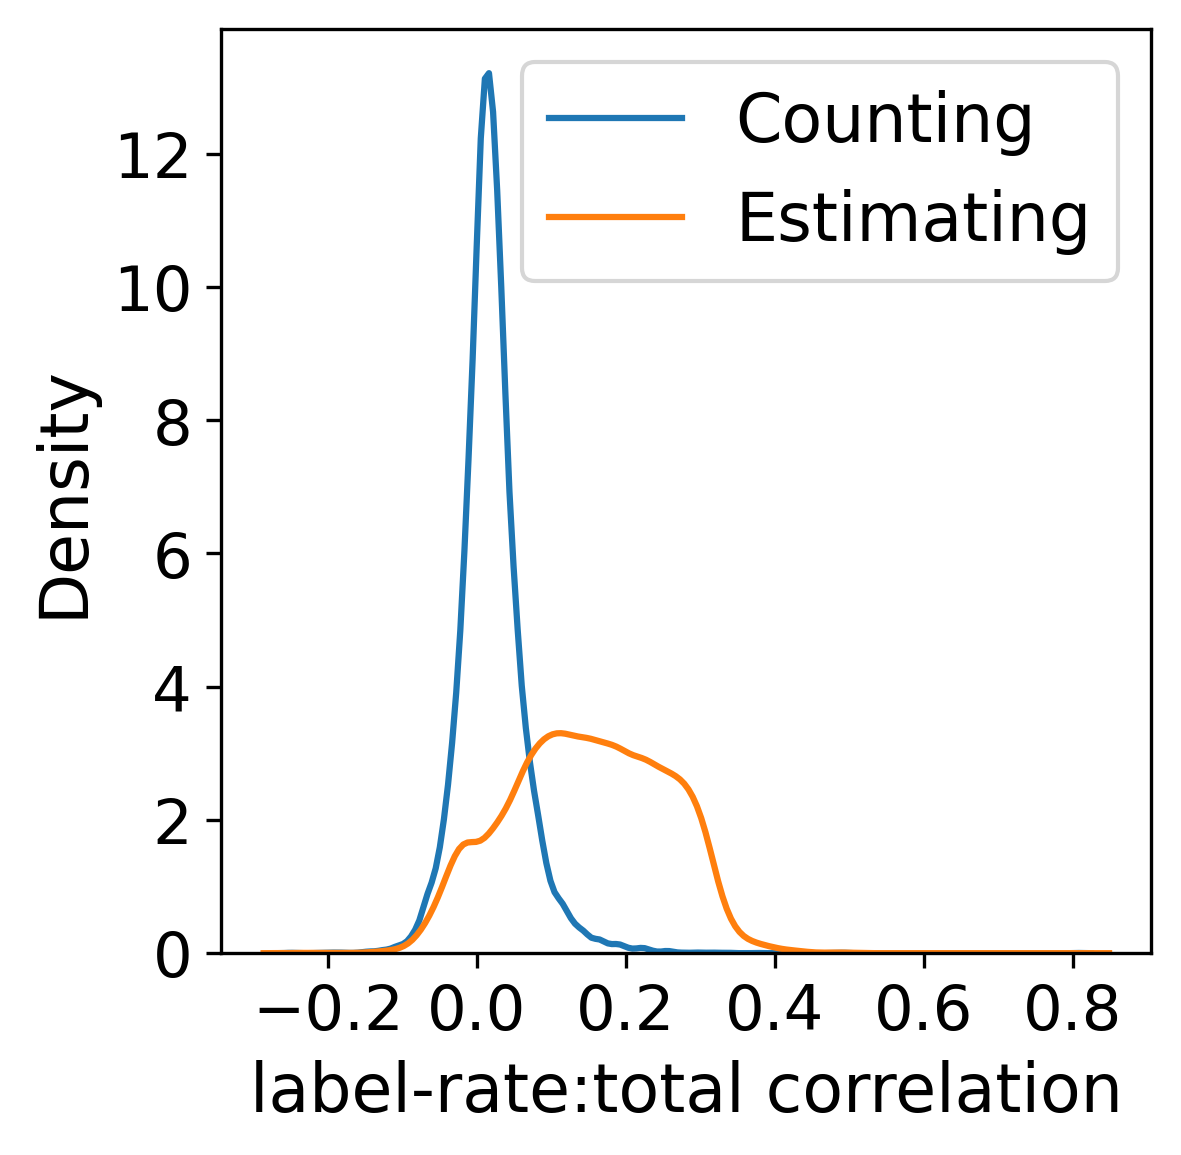

In [128]:
plt.figure(figsize=(4,4), dpi=300)
sns.kdeplot(cnt_corr, label='Counting')
sns.kdeplot(est_corr, label='Estimating')
plt.xlabel("label-rate:total correlation", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig("../figures/0.2.10_est_label_corr.png", bbox_inches='tight')
plt.show()

# SME

In [3]:
def aggregate_adatas(
    home, 
    pos_pattern='MAI',
    neg_pattern='tmp',
    method='count'):
    from tqdm import tqdm
    samples = [f for f in os.listdir(home) if pos_pattern in f]
    samples = [f for f in samples if neg_pattern not in f]
    adata_list = []
    for sample in tqdm(samples):
        try:
            adata = sc.read_h5ad(home+sample+f'/{method}/adata.h5ad')
            adata.obs.index = ['_'.join((sample,a)) for a in adata.obs.index]
            adata.obs['sample'] = sample
            adata.var['ID'] = adata.var.index
            try:
                adata.var = adata.var.set_index('gene_name')
                adata.var.index = adata.var.index.astype("string")
                adata.var_names_make_unique()
                adata.obs_names_make_unique()
                adata.strings_to_categoricals()
                adata_list.append(adata)
                clear_output(wait=True)
            except IndexError:
                pass
        except FileNotFoundError:
            print(f"{sample} not found.")
    total_adata = ann.concat(adata_list, join='outer', fill_value=0, axis=0)
    return total_adata

In [4]:
home = '/camp/lab/briscoej/working/Rory/transcriptomics/sciFATE_data/experiments/SMEx/data/all/'
adata0 = aggregate_adatas(home)

100%|██████████| 384/384 [01:40<00:00,  3.84it/s]


In [6]:
def save_file(adata, name, X='total'):
    """
    there's an issue with string formatting, which this fixes.
    """
    coldict = {}
    for col in adata.obs.columns:
        coldict[col] = [a for a in adata.obs[col]]
    new_obs = pd.DataFrame(coldict, index=list(adata.obs.index.values))

    coldict = {}
    for col in adata.var.columns:
        coldict[col] = [a for a in adata.var[col]]
    new_var = pd.DataFrame(coldict, index=list(adata.var.index.values))
    
    adata = ann.AnnData(X=adata.layers[X].copy(),
                         obs=new_obs,
                         var=new_var,
                         layers=adata.layers.copy())
    
    adata.write(name)
    
save_file(adata0, '../data/species_mixture.h5ad')

In [131]:
# threshold to remove ambient 'cells'
adata = adata0[adata0.layers['spliced'].sum(1)>1000]

hg = [a for a in adata.var_names if 'GRCh38' in a]
mg = [a for a in adata.var_names if 'mm10' in a]

cutoff=1000

had = np.array(adata[:,hg].X.sum(1))
mad = np.array(adata[:,mg].X.sum(1))

x = np.concatenate((mad,had),axis=1)

db = x[[(a>cutoff and b>cutoff) for a,b in zip(x[:,0],x[:,1])]]
ms = x[[a>cutoff and b<=cutoff for a,b in zip(x[:,0],x[:,1])]]
hm = x[[a<=cutoff and b>cutoff for a,b in zip(x[:,0],x[:,1])]]
bd = x[[a<=cutoff and b<=cutoff for a,b in zip(x[:,0],x[:,1])]]

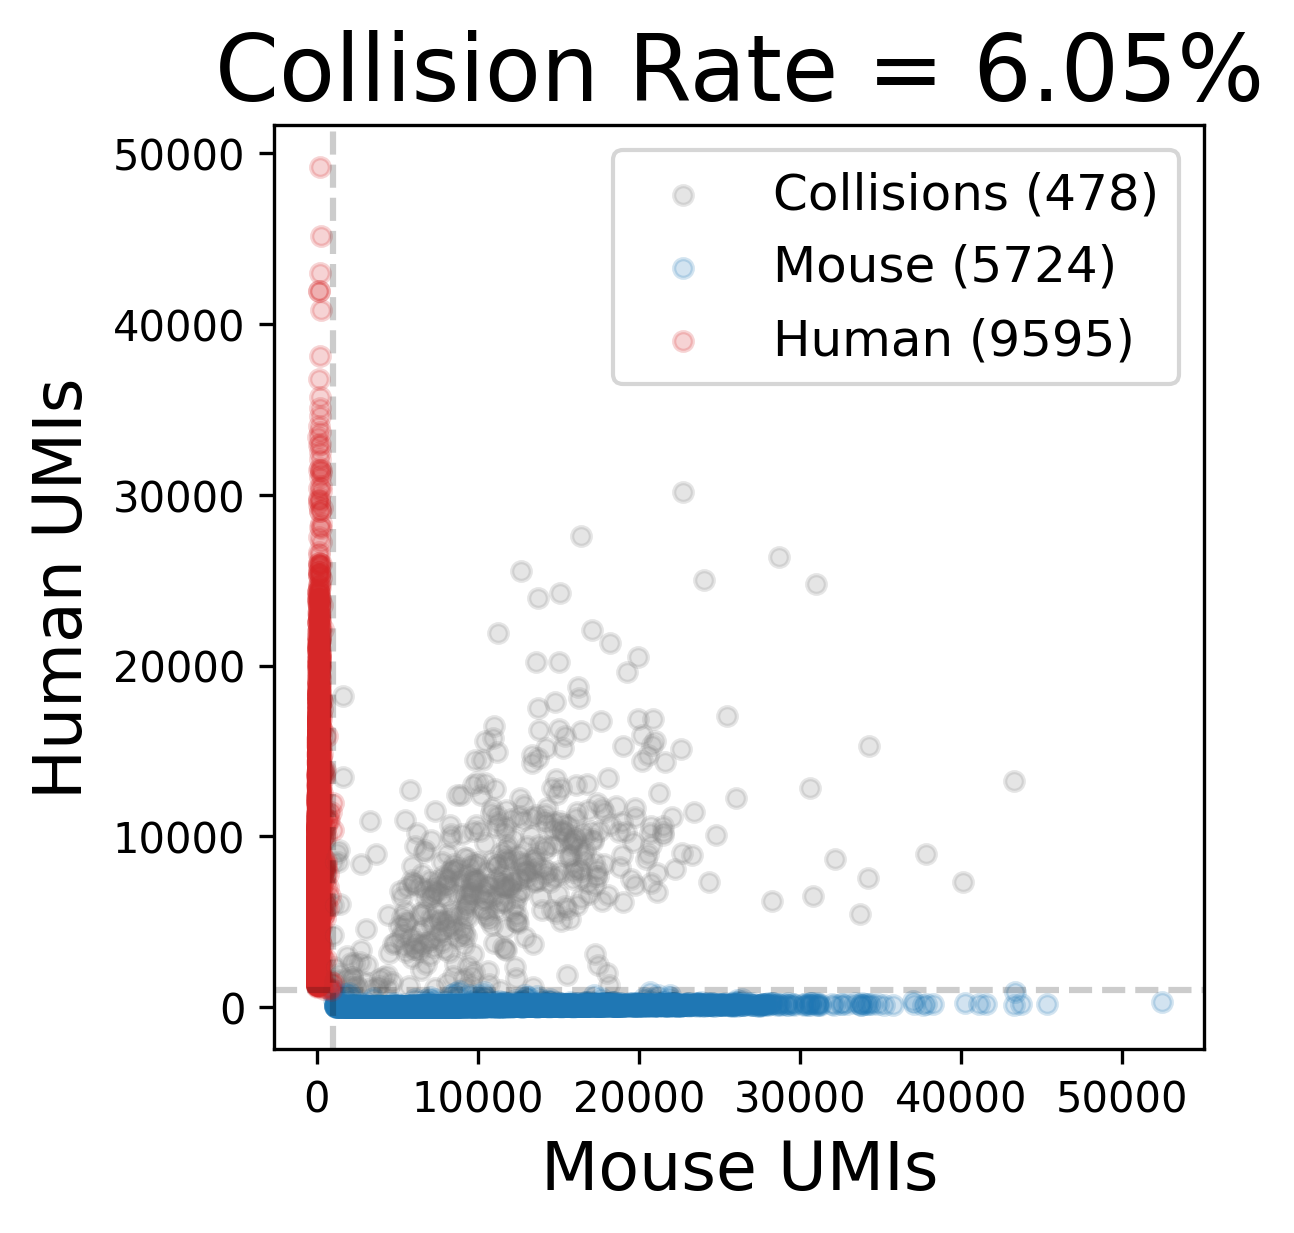

In [135]:
plt.figure(figsize=(4,4), dpi=300)
plt.scatter(db[:,0],db[:,1], alpha=0.2, c='grey', label=f'Collisions ({db.shape[0]})', s=20)
plt.scatter(ms[:,0],ms[:,1], alpha=0.2, c='tab:blue', label = f'Mouse ({ms.shape[0]})', s=20)
plt.scatter(hm[:,0],hm[:,1], alpha=0.2, c='tab:red', label = f'Human ({hm.shape[0]})', s=20)
plt.axvline(x=cutoff, c='k', alpha=0.2, linestyle='--')
plt.axhline(y=cutoff, c='k', alpha=0.2, linestyle='--')
plt.title(f'Collision Rate = {100*(len(db)/len(mad)*2):.2f}%', fontsize=22)
plt.legend(fontsize=12)
plt.xlabel("Mouse UMIs", fontsize=16)
plt.ylabel("Human UMIs", fontsize=16)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.2.11_species_mixture_experiment.png', bbox_inches='tight')
plt.show()